# Predictive maintenance
data : https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020

S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.visuals import *
from src.transform import *

In [2]:
df=pd.read_csv("./data/data.csv",index_col="UDI")

# Columns description


  <ul>
   <li>UID: unique identifier ranging from 1 to 10000</li>
   <li>product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number</li>
    <li>type: just the product type L, M or H from column 2</li>
    <li>air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K</li>
    <li>process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.</li>
    <li>rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise</li>
    <li>torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.</li>
    <li>tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.</li>
    <li>a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.</li>
</ul><br>

The machine failure consists of five independent failure modes<br>
<ul>
    <li>tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).</li>
    <li>heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.</li>
    <li>power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.</li>
    <li>overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.</li>
    <li>random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.</li>
</ul><br>
    If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.




## Data

### basic inspection

In [3]:
print(df.shape)
df.head()

(10000, 13)


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**we can see that we have 10000 rows and 13 different columns**

In [4]:
df.dtypes

Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [5]:
df.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

the target variable are machine_failure and the different categories of failures TWF, HDF, PWF, OSF, RNF, explicative variables can be Type, Air temperatures, Process Temperatures, Rotational speed, and torque

**since we have Torque and rotational speed we can calculate mechanical power
P = Torque * Rotational Speed (in rad/s)**

In [6]:
df = calculate_mechanical_power(df, speed_column="Rotational speed [rpm]", torque_column="Torque [Nm]")

In [9]:
df[["mechanical_power [W]","Rotational speed [rpm]","Torque [Nm]"]]

,mechanical_power [W],Rotational speed [rpm],Torque [Nm]
UDI,,,
1,6951.590560,1551,42.8
2,6826.722724,1408,46.3
3,7749.387543,1498,49.4
4,5927.504659,1433,39.5
5,5897.816608,1408,40.0
...,...,...,...
9996,4955.129373,1604,29.5
9997,5434.703963,1632,31.8
9998,5753.617506,1645,33.4


**let's also add the difference in temperature between the process and air temperature**

In [10]:
df["temp_diff [K]"]= df["Process temperature [K]"] - df["Air temperature [K]"]

**Missing values** 

In [11]:
df.isna().sum()

Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
mechanical_power [W]       0
temp_diff [K]              0
dtype: int64

no missing values

# Descriptive statistics

**1D**

In [14]:
explicative_variables = ['Type', 'Air temperature [K]', 'Process temperature [K]',"temp_diff [K]","Tool wear [min]",
       'Rotational speed [rpm]', 'Torque [Nm]', 'mechanical_power [W]']
target_variables = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [31]:
X= df[explicative_variables]
y= df[target_variables]

In [16]:
df[explicative_variables].describe()

,Air temperature [K],Process temperature [K],temp_diff [K],Tool wear [min],Rotational speed [rpm],Torque [Nm],mechanical_power [W]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,10.000630,107.951000,1538.776100,39.986910,6279.744953
std,2.000259,1.483734,1.001094,63.654147,179.284096,9.968934,1067.418295
min,295.300000,305.700000,7.600000,0.000000,1168.000000,3.800000,1148.440610
25%,298.300000,308.800000,9.300000,53.000000,1423.000000,33.200000,5561.184484
50%,300.100000,310.100000,9.800000,108.000000,1503.000000,40.100000,6271.027344
75%,301.500000,311.100000,11.000000,162.000000,1612.000000,46.800000,7003.002724
max,304.500000,313.800000,12.100000,253.000000,2886.000000,76.600000,10469.923005


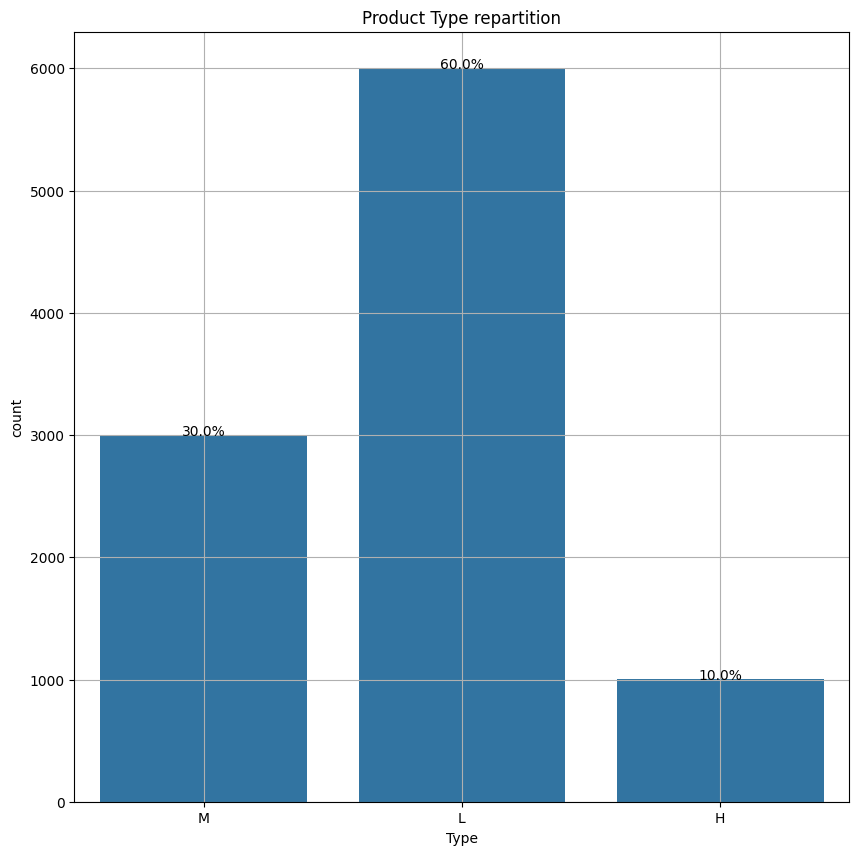

In [17]:
total = len(df)
fig=plt.figure(figsize=(10,10))
ax = sns.countplot(data=df, x="Type")
plt.title("Product Type repartition")

for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total)
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, percentage, ha="center")

plt.grid()

## Target (Machine failure)

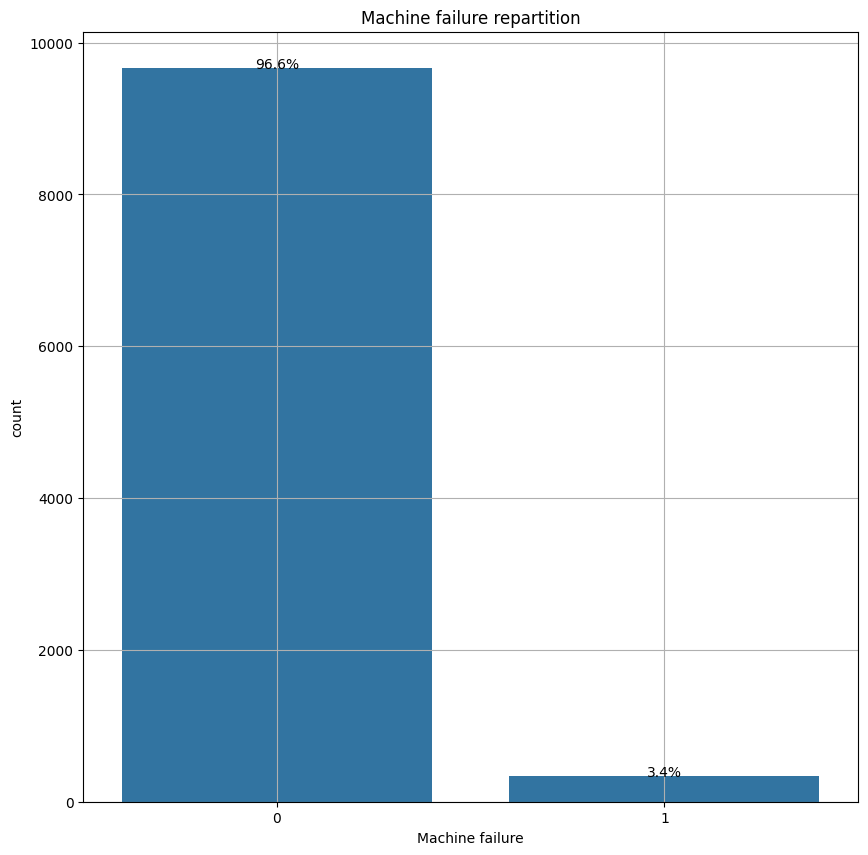

In [18]:
total = len(df)
fig=plt.figure(figsize=(10,10))
ax = sns.countplot(data=df, x="Machine failure")
plt.title("Machine failure repartition")

for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total)
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, percentage, ha="center")

plt.grid()

**we can see that we don't have a lot of machine failures in dataset**

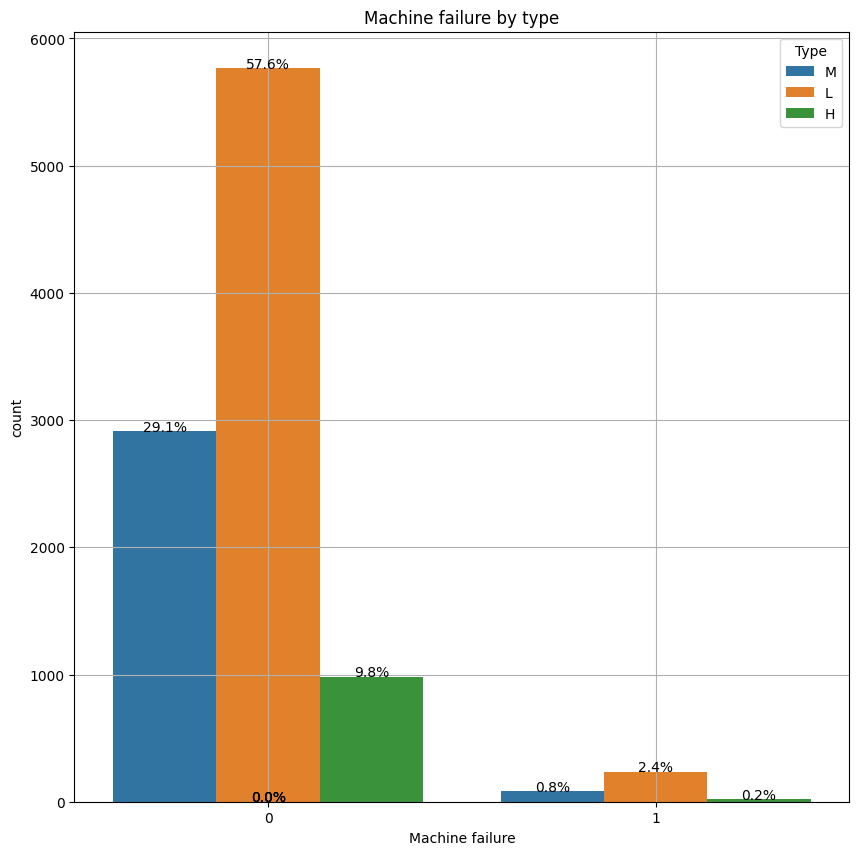

In [19]:
total = len(df)
fig=plt.figure(figsize=(10,10))
ax=sns.countplot(data=df, x="Machine failure",hue="Type")

for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total)
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, percentage, ha="center")

plt.grid()
plt.title("Machine failure by type")
plt.show()

crosstabulation Type and Machine failure

In [20]:
crosstab_result=pd.crosstab(df['Type'], df['Machine failure'])
crosstab_result

Machine failure,0,1
Type,,
H,982,21
L,5765,235
M,2914,83


**we can easily see that we have more failures with low quality products but it's also the most class**

In [21]:
# Calculate percentage per row (Type)
percentage_per_row = crosstab_result.div(crosstab_result.sum(axis=1), axis=0) * 100

# Display the percentage per row
round(percentage_per_row,2)

Machine failure,0,1
Type,,
H,97.91,2.09
L,96.08,3.92
M,97.23,2.77


**doing percentage per row  we can see that the low quality implies more frequent machine failures**

In [22]:
# Calculate percentage per column (Machine failure)
percentage_per_column = crosstab_result.div(crosstab_result.sum(axis=0), axis=1) * 100

# Display the percentage per column
round(percentage_per_column,2)


Machine failure,0,1
Type,,
H,10.16,6.19
L,59.67,69.32
M,30.16,24.48


In [25]:
def invert_one_hot_encoding(row):
    failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
    failures = [mode for mode in failure_modes if row[mode] == 1]
    
    # If no failure, return 'No Failure', otherwise join failure modes
    return ', '.join(failures) if failures else 'No Failure'

# Apply the function to each row to create the 'failure_category' column
df['failure_category'] = df.apply(invert_one_hot_encoding, axis=1)

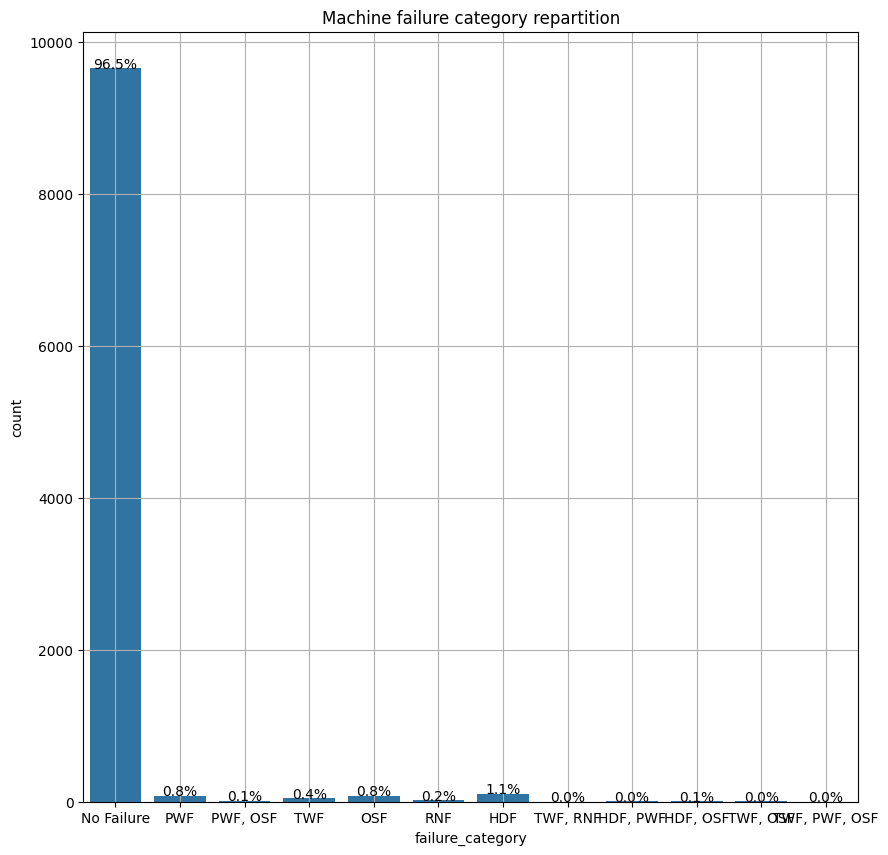

In [26]:
total = len(df)
fig=plt.figure(figsize=(10,10))
ax = sns.countplot(data=df, x="failure_category")
plt.title("Machine failure category repartition")

for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total)
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, percentage, ha="center")

plt.grid()

In [28]:
crosstab_result=pd.crosstab(df['Type'], df['failure_category'])
crosstab_result

failure_category,HDF,"HDF, OSF","HDF, PWF",No Failure,OSF,PWF,"PWF, OSF",RNF,TWF,"TWF, OSF","TWF, PWF, OSF","TWF, RNF"
Type,,,,,,,,,,,,
H,8,0,0,979,1,4,0,4,6,0,1,0
L,68,6,2,5757,73,49,8,12,24,0,0,1
M,30,0,1,2916,4,27,3,2,12,2,0,0


**associations**

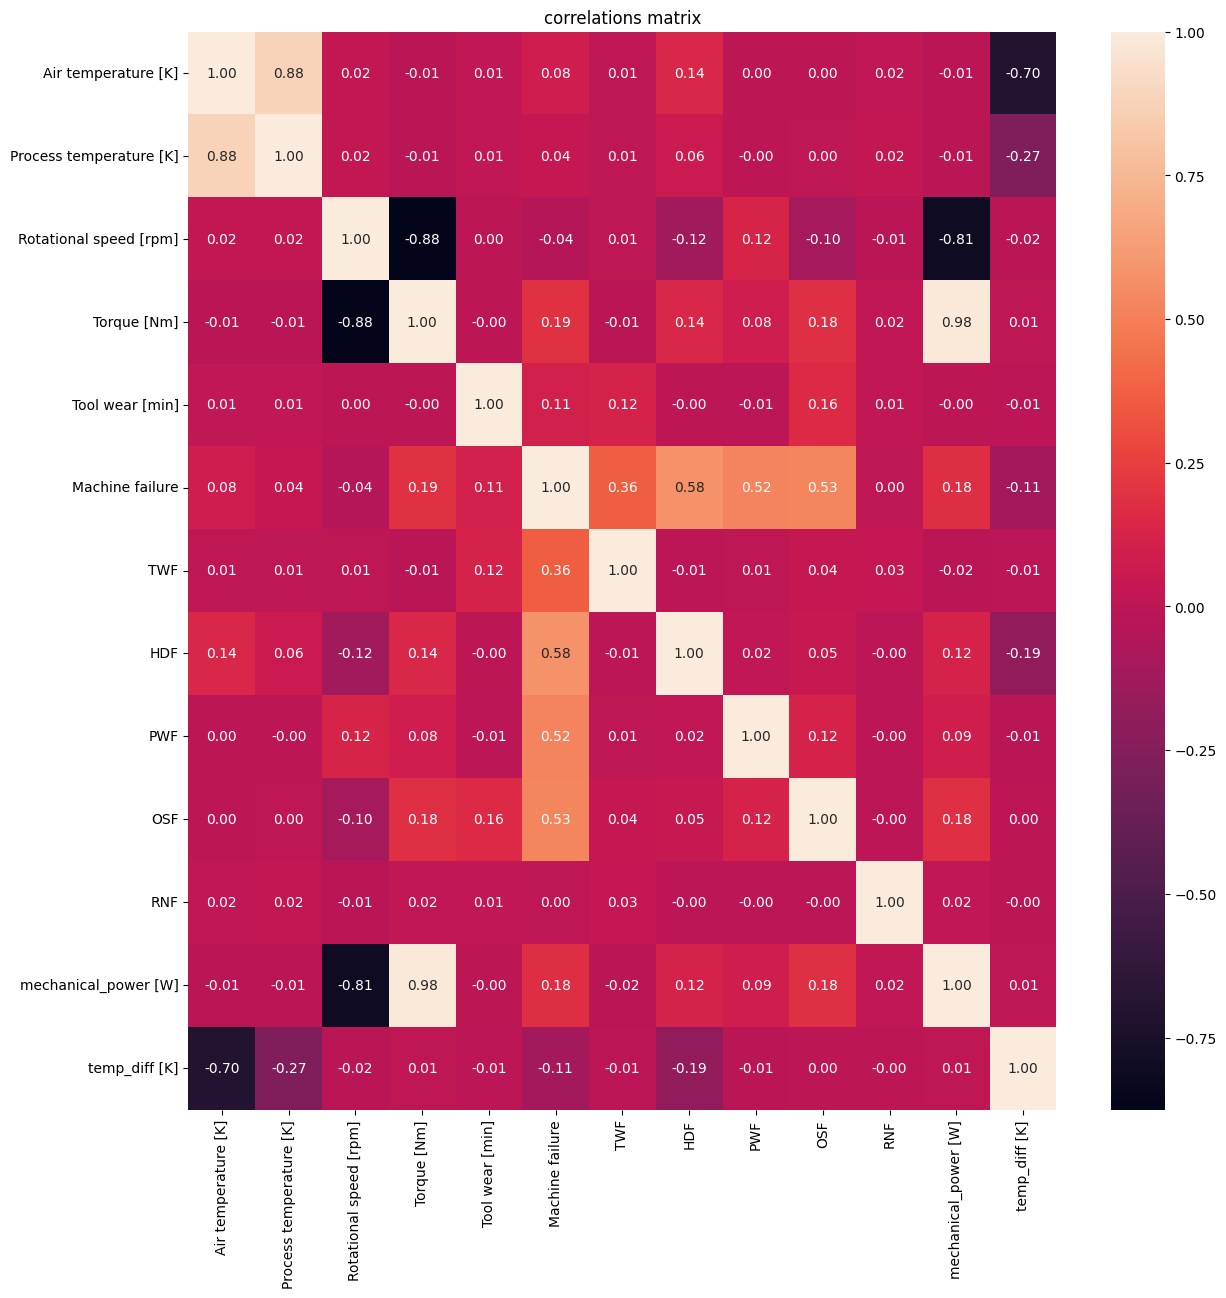

In [29]:
plt.figure(figsize=(14,14))
sns.heatmap(data=df.select_dtypes(['int','float']).corr(),annot=True, fmt=".2f")
plt.title("correlations matrix")

plt.show()

<Figure size 1000x1000 with 0 Axes>

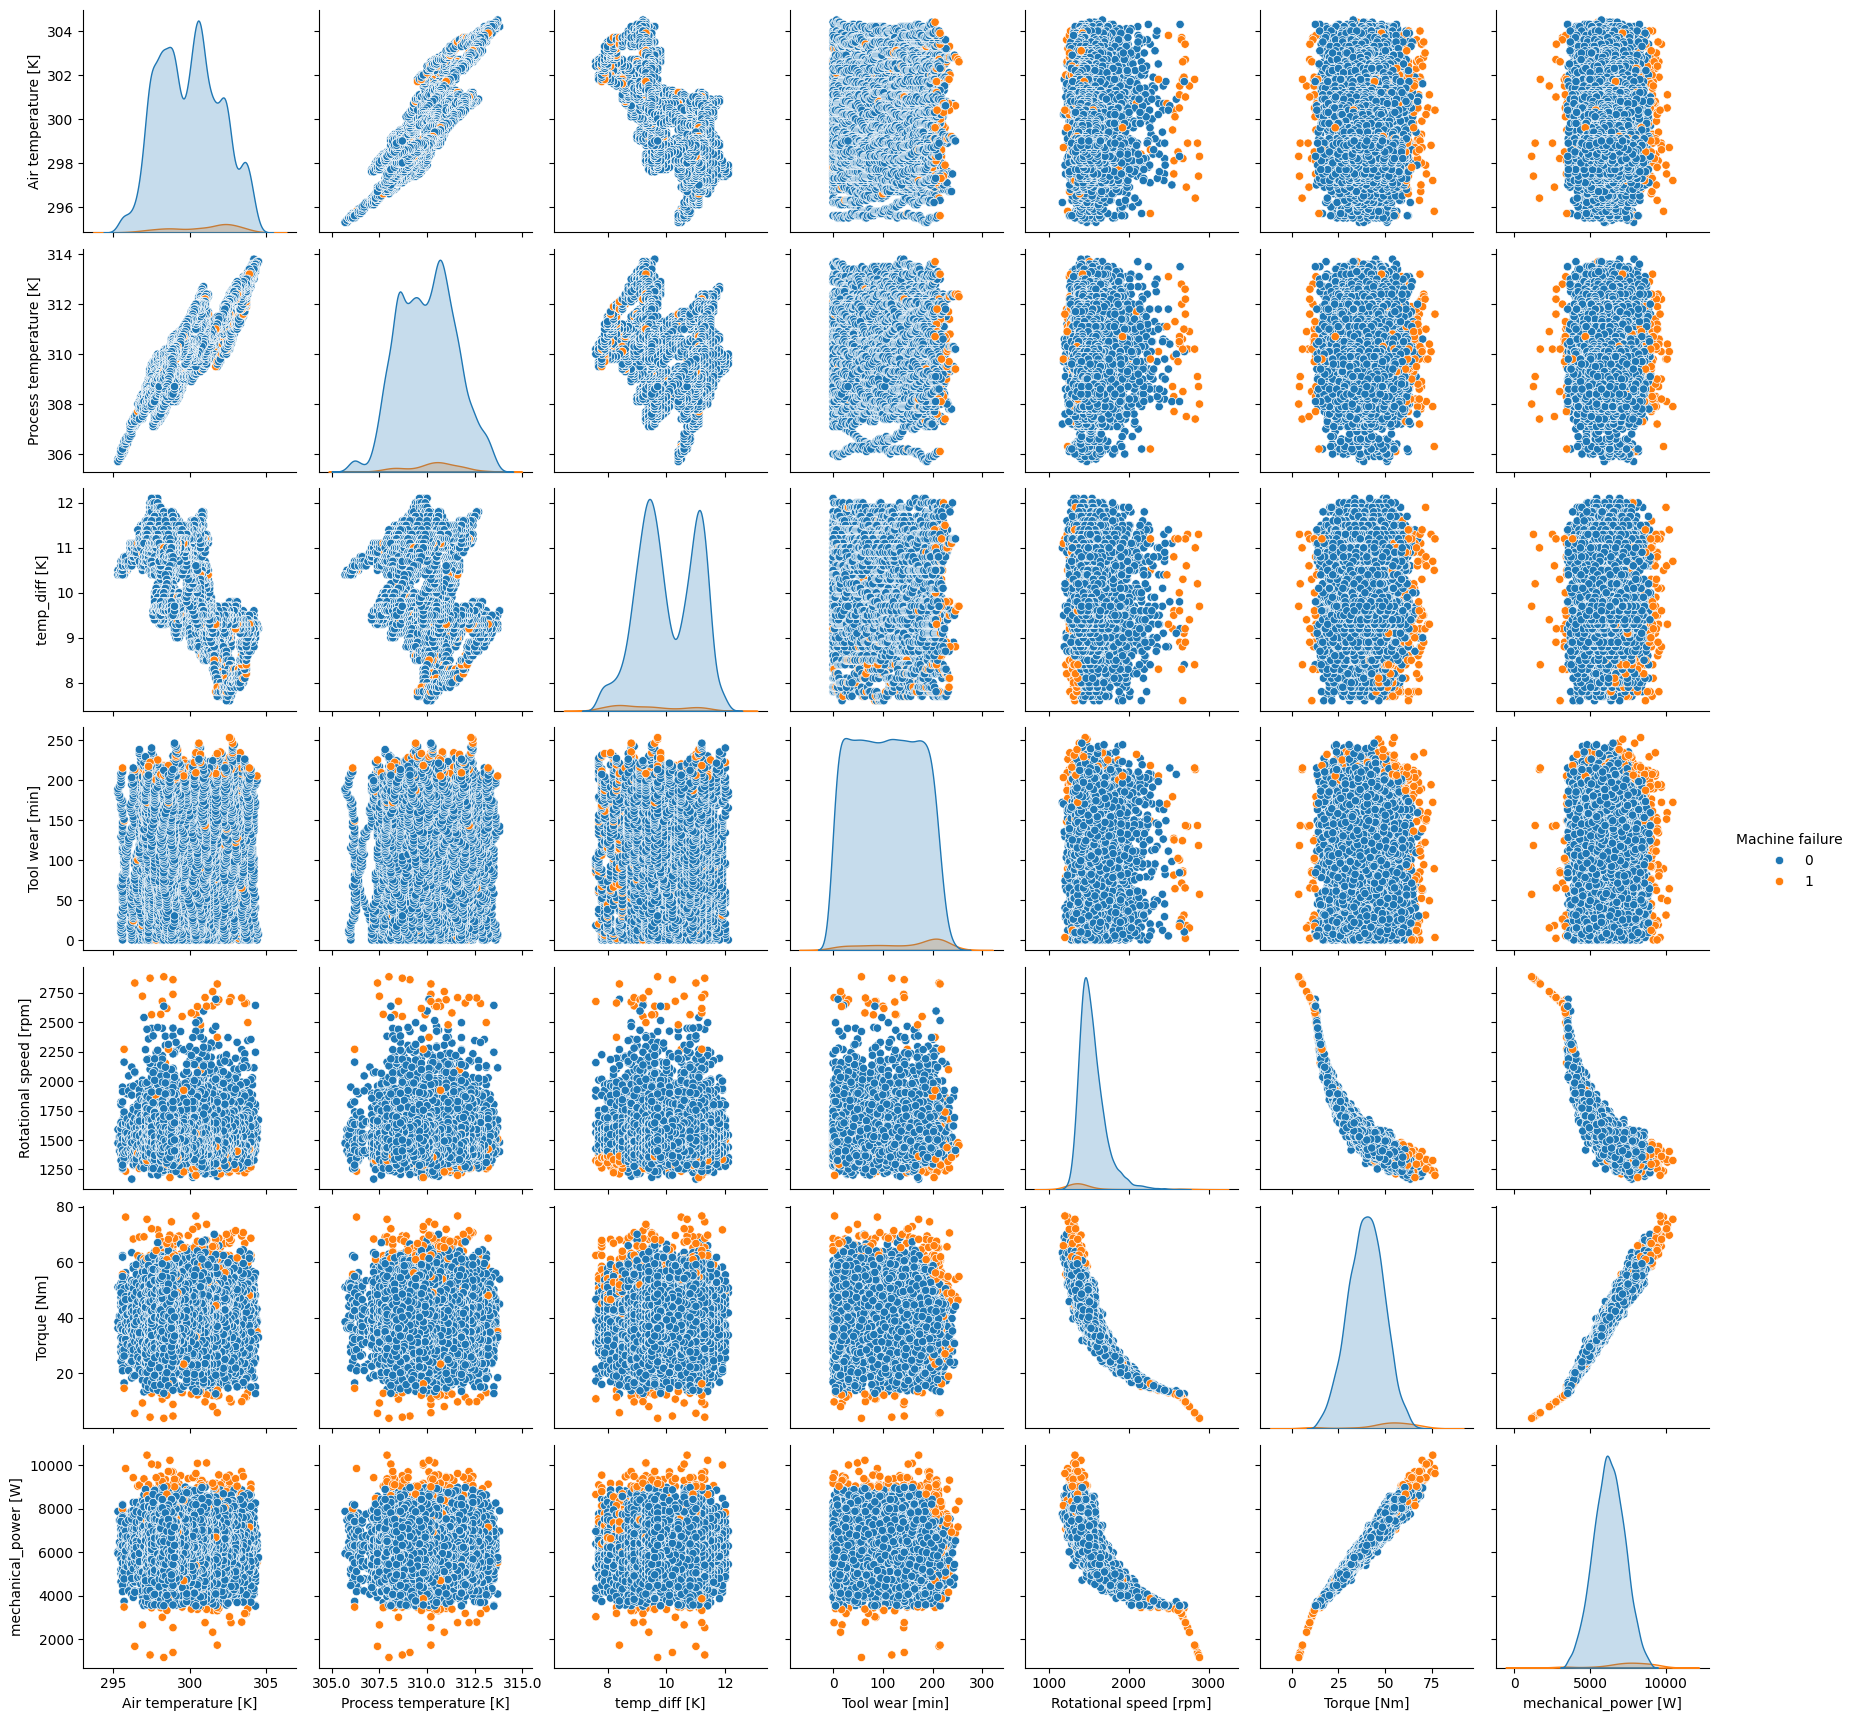

In [30]:
plt.figure(figsize=(10,10))
sns.pairplot(data=df[explicative_variables+["Machine failure"]],hue="Machine failure")
plt.show()